In [ ]:
%load_ext autoreload
%autoreload 2

from spectrum import Spectrum
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from atomic_lines import NA_I_LINES, K_I_LINES, plot_atomic_lines, radial_velocity_km_s


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reading data for target HD185859: 100%|██████████| 166/166 [00:00<00:00, 5910.78it/s]


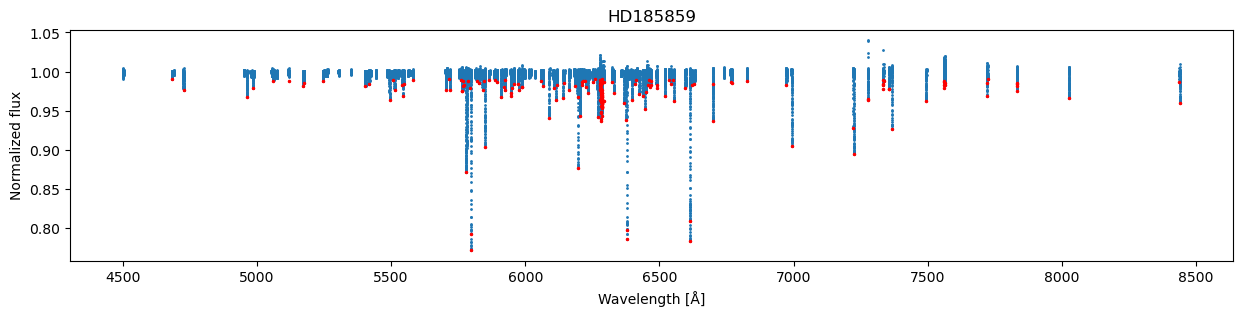

In [10]:
hd185859 = Spectrum('HD185859')
peak_indices, _ = find_peaks(-hd185859.flux, height=-0.99, prominence=0.01)

spectrum_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))
hd185859.plot(ax)
ax.plot(hd185859.wavelength[peak_indices], hd185859.flux[peak_indices], '.', ms=3, color='red')
# ax.set_xlim(6277, 6290)
# ax.set_xlim(5800, 6000)

Optimal tollerance 1.013
Radial velocity based on Na I: -2303.39 km/s


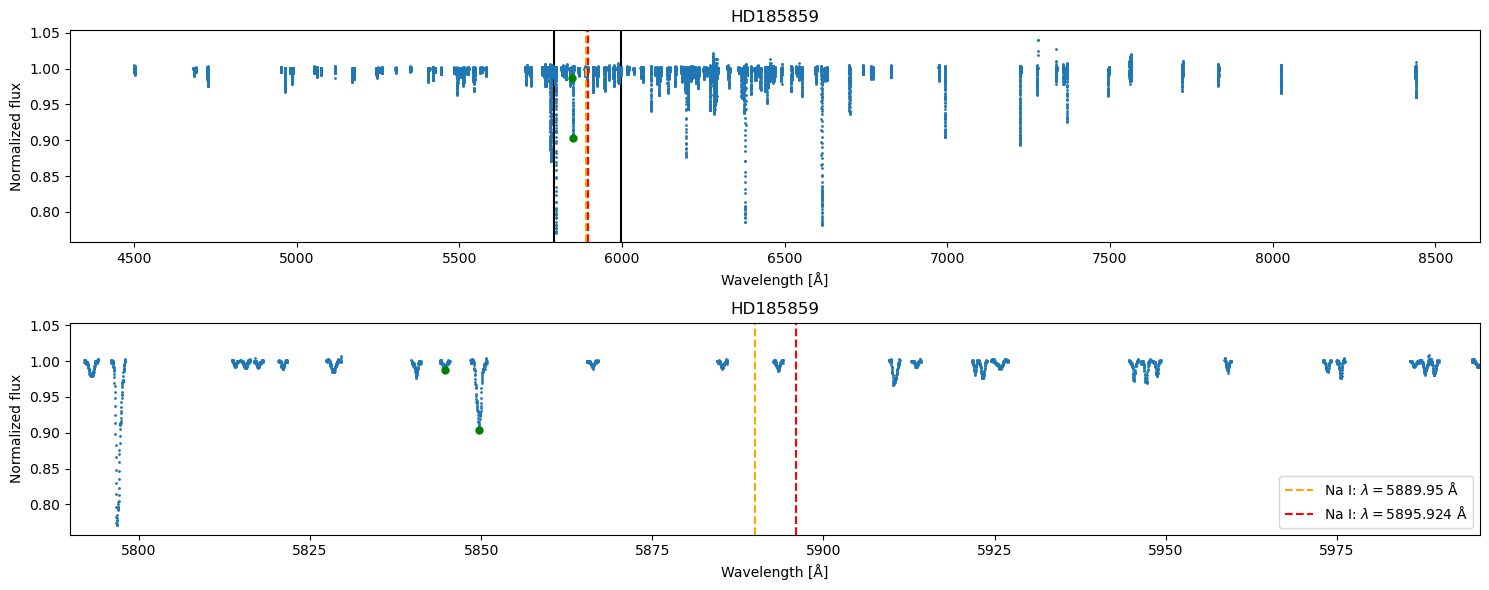

In [8]:
na_peaks, = plot_atomic_lines(hd185859, NA_I_LINES[0], NA_I_LINES[1], (100, 100))
print(f'Radial velocity based on Na I: {radial_velocity_km_s(na_peaks[1], NA_I_LINES[0][1]):4g} km/s')

Optimal tollerance 0.504
Radial velocity based on Na I: -12960.2 km/s


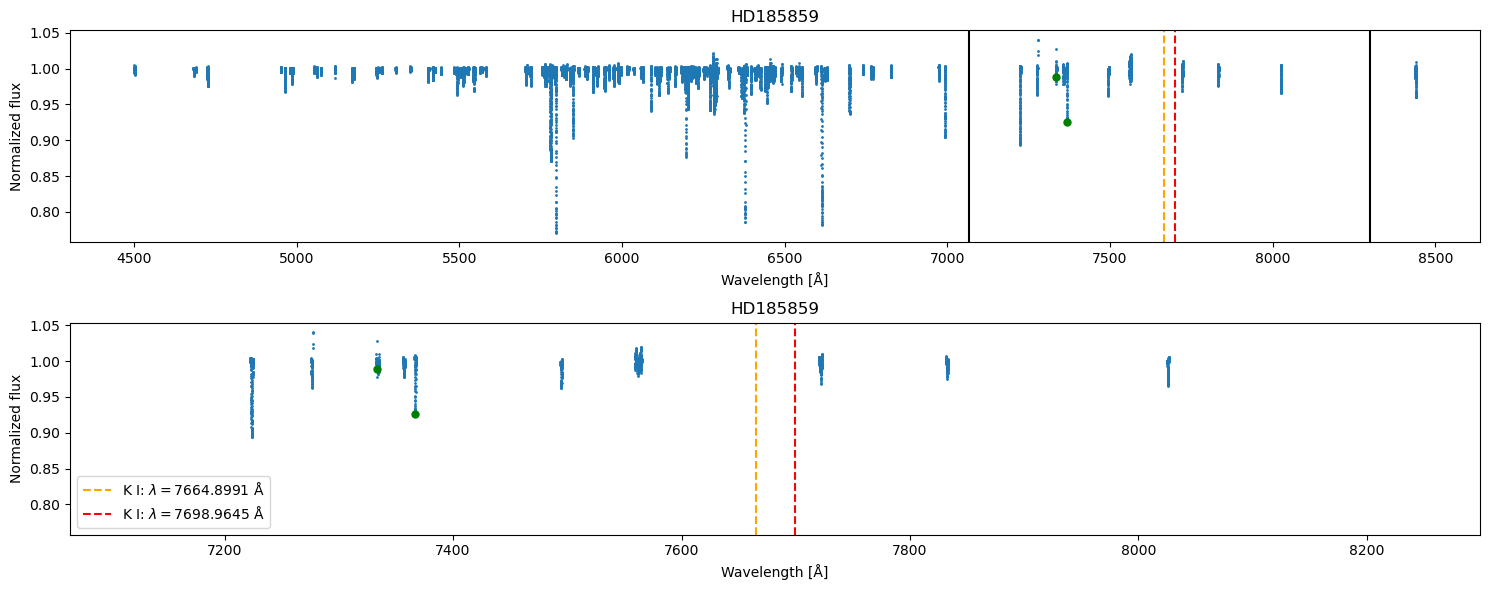

In [9]:
k_peaks, = plot_atomic_lines(hd185859, K_I_LINES[0], K_I_LINES[1], (600, 600))
print(f'Radial velocity based on Na I: {radial_velocity_km_s(k_peaks[1], K_I_LINES[0][1]):4g} km/s')